In [4]:
import polars as pl
import matplotlib.pyplot as plt

In [2]:
def create_trips_df(xwalk:pl.DataFrame, rts:list, is_scheduled:bool = False):
    """
    Given rts to pids xwalk and a list of rts, create a df for all the trips for the rts
    """
    
    trips = []

    # just look at the rts for schedule
    if is_scheduled:
        iter = rts
        file_DIR = '../cta-stop-etl/out/clean_timetables/rt{rt}_timetable.parquet'
        error = "Do not have timetable for route {rt}. Skipping"
    else: 
        pids = xwalk.filter(pl.col("rt").is_in(rts)).unique("pid")
        rt_pid = pids.rows()
        iter = rt_pid
        
        file_DIR = '../cta-stop-etl/out/trips/trips_{pid}_full.parquet'
        error = "Do not have pattern {pid} for route. Skipping"
        

    for obj in iter:
        if is_scheduled:
            rt = obj
            template_values = {"rt": rt}
            
        else:
            rt, pid = obj
            template_values = {"pid": pid}

        try:
            df_trips = pl.read_parquet(file_DIR.format(**template_values))
        except FileNotFoundError:
            print(error.format(**template_values))
            continue
            
        if not is_scheduled:
            # for now
            df_trips = df_trips.filter(pl.col('typ') == 'S')
            df_trips = df_trips.with_columns(pl.lit(pid).cast(pl.Int64).alias('pid'),
                                            pl.lit(rt).cast(pl.Int64).alias('rt'))
        
        
        trips.append(df_trips)    

    df_trips_all = pl.concat(trips)

    if is_scheduled:
        df_trips_all = df_trips_all.rename({'route_id': 'rt'})
        df_trips_all = df_trips_all.with_columns(
            trip_id = pl.col('schd_trip_id') + pl.col('bus_stop_time').dt.date().cast(pl.String)
            )
    else:
        df_trips_all = df_trips_all.rename({"unique_trip_vehicle_day": "trip_id", 'stpid': 'stop_id'})

    return df_trips_all


def time_to_next_stop(trips_df:pl.DataFrame, group_type:str, is_daytime:bool = True, ):
    
    if is_daytime:
        trips_df = trips_df.filter(pl.col('bus_stop_time').dt.hour().is_between(6, 20))

    trips_df = trips_df.sort(by=['trip_id', 'bus_stop_time'])
    trips_df = trips_df.with_columns(time_to_next_stop =
        (pl.col("bus_stop_time").shift(-1) - pl.col("bus_stop_time"))
        .over(pl.col("trip_id").rle_id()))
    
    
    trips_df = trips_df.with_columns((pl.col('bus_stop_time').dt.hour()).alias('hour'), 
                      (pl.col('bus_stop_time').dt.month()).alias('month'),
                      (pl.col('bus_stop_time').dt.year()).alias('year'),
                        (pl.col('bus_stop_time').dt.day()).alias('day'))

    if group_type == 'bus_stop':
        group_type = ['pid', 'stop_id']
    else:
        group_type = [group_type]

    trips_df = trips_df.group_by(['rt',*group_type]).agg(
            median = pl.median("time_to_next_stop"),
            mean = pl.mean("time_to_next_stop"),
            max = pl.max("time_to_next_stop"),
            min = pl.min("time_to_next_stop"),
            std = pl.std("time_to_next_stop"),
            q25 = pl.col('time_to_next_stop').quantile(0.25),
            q75 = pl.col('time_to_next_stop').quantile(0.75),
    )
    
    return trips_df.sort(['rt',*group_type])

def find_metric(is_schedule:bool, metric:str, rts:list, group_type:str = 'stop_id'):
    """
    Calculate a metric for the given rts for other real bus locations of from the schedule.
    """

    rt_to_pid = pl.read_parquet('rt_to_pid.parquet')

    trips_df = create_trips_df(rt_to_pid, rts = rts, is_scheduled=is_schedule)

    if metric == 'time_to_next_stop':
        return time_to_next_stop(trips_df,group_type = group_type)
    


In [8]:
groupby = 'day'
schedule = find_metric(is_schedule = True, metric = 'time_to_next_stop', rts = ['28'], group_type = groupby)
schedule = schedule.select([groupby,'median'])
Buses = find_metric(is_schedule = False, metric = 'time_to_next_stop', rts = ['28'], group_type = groupby)
Buses = Buses.select([groupby,'median'])


join = schedule.join(Buses, on=groupby, how="inner")
with pl.Config(tbl_rows=24):
    print(join.rename({"median": "schedule_median", "median_right": "real_median"}))

Do not have pattern 2268 for route. Skipping
Do not have pattern 2271 for route. Skipping
shape: (31, 3)
┌─────┬─────────────────┬─────────────────┐
│ day ┆ schedule_median ┆ real_median     │
│ --- ┆ ---             ┆ ---             │
│ i8  ┆ duration[ns]    ┆ duration[ns]    │
╞═════╪═════════════════╪═════════════════╡
│ 1   ┆ 38s             ┆ 39s 118995333ns │
│ 2   ┆ 38s             ┆ 38s 416187602ns │
│ 3   ┆ 38s             ┆ 39s 143489438ns │
│ 4   ┆ 37s             ┆ 38s 65621415ns  │
│ 5   ┆ 38s             ┆ 38s 938951173ns │
│ 6   ┆ 39s             ┆ 39s 74281117ns  │
│ 7   ┆ 38s             ┆ 39s 258044522ns │
│ 8   ┆ 38s             ┆ 38s 983316613ns │
│ 9   ┆ 38s             ┆ 38s 551744486ns │
│ 10  ┆ 38s             ┆ 38s 589705572ns │
│ 11  ┆ 38s             ┆ 39s 96476328ns  │
│ 12  ┆ 38s             ┆ 38s 835935159ns │
│ …   ┆ …               ┆ …               │
│ 20  ┆ 39s             ┆ 38s 852976661ns │
│ 21  ┆ 38s             ┆ 38s 620193544ns │
│ 22  ┆ 39s    

In [47]:
def chart_schedule_vs_real(schedule, real, groupby):
    

    fig, ax = plt.subplots()
    ax.plot(schedule[groupby], schedule['median'], label = 'Schedule')
    ax.plot(real[groupby], real['median'], label = 'Real')
    
    ax.legend()
    plt.show()
    


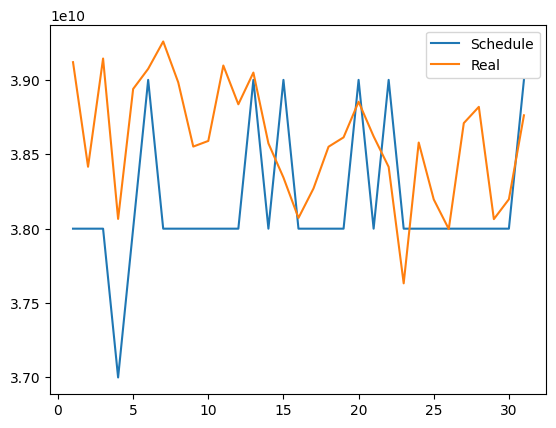

In [48]:
chart_schedule_vs_real(schedule, Buses, groupby)